# Reading and formatting the XT data


In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys
import pickle
import os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Customize
sns.set_style("whitegrid")
sns.set_context('talk')
%matplotlib inline

# XML
import xmltodict

In [2]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists

# Find host name
import socket
if socket.gethostname().find('.')>=0:
    name=socket.gethostname()
else:
    name=socket.gethostbyaddr(socket.gethostname())[0]

# Determine which machine the script is running on; set up directory names
if 'btgmm8' in name:
    dirPre = '/Users/karllapo/Desktop/'
elif 'klapos' in name:
    dirPre = '/Users/karllapo/gdrive/DarkMix/'

dirData = dirPre + 'proj/VertHarpExp2017Kloendeel/data/DTS_XT_VHSRE'
dirPrint = dirPre + 'graphics'
dirProcessed = dirPre + 'proj/VertHarpExp2017Kloendeel/data/DTS_XT_VHSRE_processed'

## Location library for labeling

In [5]:
def labelLocation(ds):

    location = {
        ########################
        ## Near vertical harp ##
        ########################
        # Segment 1, up and over ~ 47.3 to 50.8. 2m vertical separation,
        # tentatively assign 47.3 to 48.5 as the upward limb.
        'vertHarpNear_1': [47.3, 48.5],
        # Segment 2, up and over ~ 47.3 to 50.8. 2m vertical separation,
        # tentatively assign 50.8 to 49.3 as the downward limb.
        'vertHarpNear_2': [49.3, 50.8],
        # Segment 3, up and over ~ 51.5 to 54.9. 2m vertical separation,
        # tentatively assign 51.5 to 53.0 as the upward limb.
        'vertHarpNear_3': [51.5, 53.0],
        # Segment 4, up and over ~ 51.5 to 54.9. 2m vertical separation,
        # tentatively assign 53.4 to 54.9 as the downward limb.
        'vertHarpNear_4': [53.4, 54.9],

        #######################
        ## Far vertical harp ##
        #######################
        # Segment 1, up and over ~ 326.2 to 329.75. 2m vertical separation,
        # tentatively assign 326.2 to 327.7 as the upward limb.
        'vertHarpFar_1': [326.2, 327.7],
        # Segment 2, up and over ~ 326.2 to 329.75. 2m vertical separation,
        # tentatively assign 329.75 to 328.25 as the downward limb.
        'vertHarpFar_2': [328.25, 329.75],
        # Segment 3, up and over ~ 330.4 to 333.75. 2m vertical separation,
        # tentatively assign 330.4 to 331.9 as the upward limb.
        'vertHarpFar_3': [330.4, 331.9],
        # Segment 4, up and over ~ 330.4 to 333.75. 2m vertical separation,
        # tentatively assign 332.25 to 333.75 as the downward limb.
        'vertHarpFar_4': [332.25, 333.75],


        ######################
        ## Horizontal Array ##
        ######################
        'Horizontal - 86cm': [245, 294.5],
        'Horizontal - 84cm': [192.25, 242],
        'Horizontal - 60.5cm': [136, 185.5],
        'Horizontal - 56cm': [82.5, 132],

        #######################
        ## Temperature Baths ##
        #######################
        'warmBathNear': [29, 33],
        'coldBathNear': [17, 22],
        'warmBathFar': [346, 351],
        'coldBathFar': [357, 362],
    }

    # Assign location tags
    ds.coords['location'] = (('LAF'), [None] * ds.LAF.size)
    ds.attrs['locations'] = ';'.join(list(location.keys()))
    for l in location:
        ds.coords['location'].loc[(ds.LAF > location[l][0]) & (ds.LAF < location[l][-1])] = l

    # Assign height values
    locationHeights = {
        'Horizontal - 86cm': 0.86,
        'Horizontal - 84cm': 0.84,
        'Horizontal - 60.5cm': 0.605,
        'Horizontal - 56cm': 0.56,
    }

    return(ds)

# Read XML files

In [5]:
def readDumbXMLFiles(dumbXMLFile):
    with open(dumbXMLFile) as dumb:
        doc = xmltodict.parse(dumb.read())
    
    # Remove all of the bullshit
    doc = doc['logs']['log']
    
    # Extract units/metadata info out of xml dictionary
    metaData = {'LAF_beg': float(doc['startIndex']['#text']),
                'LAF_end': float(doc['endIndex']['#text']),
                'dLAF': float(doc['stepIncrement']['#text']),
                'dt_start': pd.to_datetime(doc['startDateTimeIndex'], infer_datetime_format=True),
                'dt_end': pd.to_datetime(doc['endDateTimeIndex'], infer_datetime_format=True),
                'probe1Temperature': float(doc['customData']['probe1Temperature']['#text']),
                'probe2Temperature': float(doc['customData']['probe2Temperature']['#text']),
                'fiberOK': int(doc['customData']['fibreStatusOk']),
               }

    # Extract data
    data = doc['logData']['data']

    numEntries = np.size(data)
    LAF = np.empty(numEntries)
    Ps = np.empty_like(LAF)
    Pas = np.empty_like(LAF)
    temp = np.empty_like(LAF)

    for dnum, dlist in enumerate(data):
        LAF[dnum], Ps[dnum], Pas[dnum], temp[dnum] = list(map(float, dlist.split(',')))

    actualData = pd.DataFrame.from_dict({'LAF': LAF, 'Ps': Ps, 'Pas': Pas, 'temp': temp}).set_index('LAF')
    
    
    return(actualData, metaData)

procFlag = True
if procFlag:
    # List of files to iterate over
    os.chdir(dirData)
    dirCon = [dC for dC in os.listdir() if 'channel 1' in dC]
    nTotal = np.size(dirCon)
    ds = None

    for nDumb, someDumbFiles in enumerate(dirCon):
        if '.xml' in someDumbFiles:
            print("\r", someDumbFiles + 'File ' + str(nDumb) + ' of ' + str(nTotal), end="")
        else:
            continue

        # Read the file
        df, meta = readDumbXMLFiles(someDumbFiles)

        # Create a temporary xarray Dataset
        temp_Dataset = xr.Dataset.from_dataframe(df)
        temp_Dataset.coords['time'] = meta['dt_start']
        temp_Dataset['probe1Temperature'] = meta['probe1Temperature']
        temp_Dataset['probe2Temperature'] = meta['probe2Temperature']
        temp_Dataset['fiberStatus'] = meta['fiberOK']

        if ds:
            ds = xr.concat([ds, temp_Dataset], dim='time')
        else:
            ds = temp_Dataset

        # Chunking/saving to avoid lock-up
        if np.mod(nDumb + 1, 1000) == 0:
            os.chdir(dirProcessed)
            numChunk = np.floor_divide(nDumb, 1000)
            ds.attrs = {'LAF_beg': meta['LAF_beg'],
                        'LAF_end': meta['LAF_end'],
                        'dLAF': meta['dLAF']}
            ds = labelLocation(ds)
            ds.to_netcdf('VHRSE_chunk' + str(numChunk) + '.nc', 'w')
            ds.close()
            ds = None
            os.chdir(dirData)


 channel 1_20170905152710726.xmlFile 11277 of 11278hannel 1_20170904220435622.xmlFile 1047 of 11278channel 1_20170905023039772.xmlFile 4055 of 11278channel 1_20170905150236509.xmlFile 11001 of 11278channel 1_20170905151126762.xmlFile 11100 of 11278

<xarray.Dataset>
Dimensions:            (LAF: 18579, time: 2403)
Coordinates:
  * LAF                (LAF) float64 -222.9 -222.6 -222.4 -222.1 -221.8 ...
    location           (LAF) object '' '' '' '' '' '' '' '' '' '' '' '' '' ...
  * time               (time) datetime64[ns] 2017-09-05T07:28:29 ...
Data variables:
    Pas                (time, LAF) float64 0.8245 0.4708 -1.112 0.4331 2.459 ...
    Ps                 (time, LAF) float64 2.052 1.205 -0.2278 -1.543 ...
    temp               (time, LAF) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    probe1Temperature  (time) float64 -0.007845 -0.000351 -0.0004115 ...
    probe2Temperature  (time) float64 37.55 37.54 37.55 37.55 37.55 37.55 ...
    fiberStatus        (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    probeColdBath      (time) float64 -0.007845 -0.000351 -0.0004115 ...
    probeWarmBath      (time) float64 37.55 37.54 37.55 37.55 37.55 37.55 ...
Attributes:
    LAF_beg:    -222.866
    LAF_end:    4499.648
    

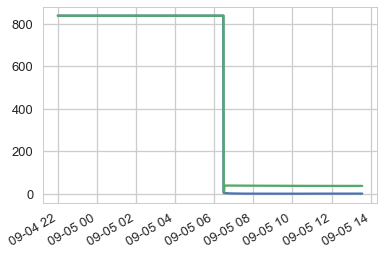

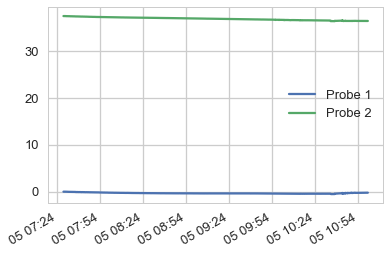

In [12]:
#########################
## Load processed data ##
#########################
dirPrint = dirPre + 'graphics'
dirProcessed = dirPre + 'proj/VertHarpExp2017Kloendeel/data/DTS_XT_VHSRE_processed'

os.chdir(dirProcessed)
ncFiles = ['VHRSE_chunk' + str(nFile) + '.nc' for nFile in np.arange(1, 10)]
ds = xr.open_mfdataset(ncFiles)

# Check probe bath temperatures
plt.plot(ds.time, ds.probe1Temperature)
plt.plot(ds.time, ds.probe2Temperature)
plt.gcf().autofmt_xdate()

##################
## Data Munging ##
##################

# Extract out the XT times when it was managing the full experiment
expIndex = (ds.probe1Temperature < 100) & (ds.probe2Temperature < 100)\
            & (ds.probe2Temperature > 30) & (ds.probe1Temperature < 0)
ds = ds.isel(time=(expIndex == True))
ds = ds.sel(time=slice(pd.Timestamp(ds.time[0].values).to_pydatetime(), '2017-09-05 11:00'))

# Create a continuous time series
d1 = pd.Timestamp(ds.time[0].values).to_pydatetime()
d2 = pd.Timestamp(ds.time[-1].values).to_pydatetime()
fullTime = pd.date_range(start=d1, end=d2, freq='5s')
ds.reindex({'time': fullTime}, method='nearest', tolerance=timedelta(seconds=5))

# Plot the resulting Dataset
fig, ax = plt.subplots(1, 1)
ax.plot(ds.time, ds.probe1Temperature, label='Probe 1')
ax.plot(ds.time, ds.probe2Temperature, label='Probe 2')
fig.autofmt_xdate()
ax.legend()

# Assign probes the descriptive names
ds['probeColdBath'] = (('time'), ds.probe1Temperature.values)
ds['probeWarmBath'] = (('time'), ds.probe2Temperature.values)

# Show the finalized dataset
print(ds)

# Save the finalized dataset
ds.to_netcdf('VHRSE_XT_processed.nc')

---
#### Notes:
    - I am using the PT100 temperature time seires to index when the XT was running the long cable during the experiment.
    - Additionally, requiring that the PT100s read physically meaningful temperatures (warm bath > 30; cold bath < 30).

##### Psuedo-code:
```
expIndex = PT100 temperature < 100
ds = ds where expIndex is True    
```

##### Calibration baths
- probe 1 is in the cold bath
- probe 2 is in the warm bath
---

## Data quality check
In particular, this sort of data check should be used to look for step losses or other odd behavior.

In [7]:
# Location dictionary
location = {

    ########################
    ## Near vertical harp ##
    ########################
    'vertHarpNear' : [47.3, 54.9],

    #######################
    ## Far vertical harp ##
    #######################
    # Segment 1, up and over ~ 326.2 to 329.75. 2m vertical separation,
    # tentatively assign 326.2 to 327.7 as the upward limb.
    'vertHarpFar': [326.2, 333.75],


    ######################
    ## Horizontal Array ##
    ######################
    'Horizontal - 86cm': [245, 294.5],
    'Horizontal - 84cm': [192.25, 242],
    'Horizontal - 60.5cm': [136, 185.5],
    'Horizontal - 56cm': [82.5, 132],

    #######################
    ## Temperature Baths ##
    #######################
    'warmBathNear': [29, 34],
    'coldBathNear': [17, 22],
    'warmBathFar': [346, 351],
    'coldBathFar': [357, 362],
    }

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log


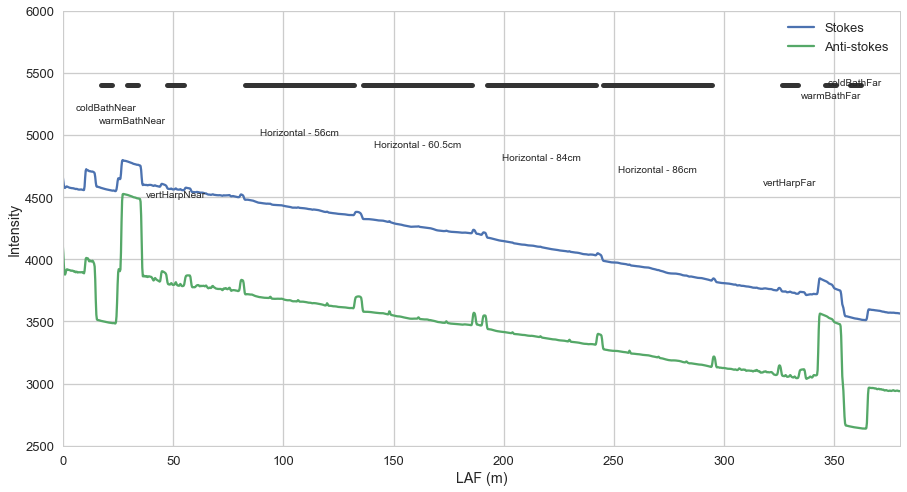

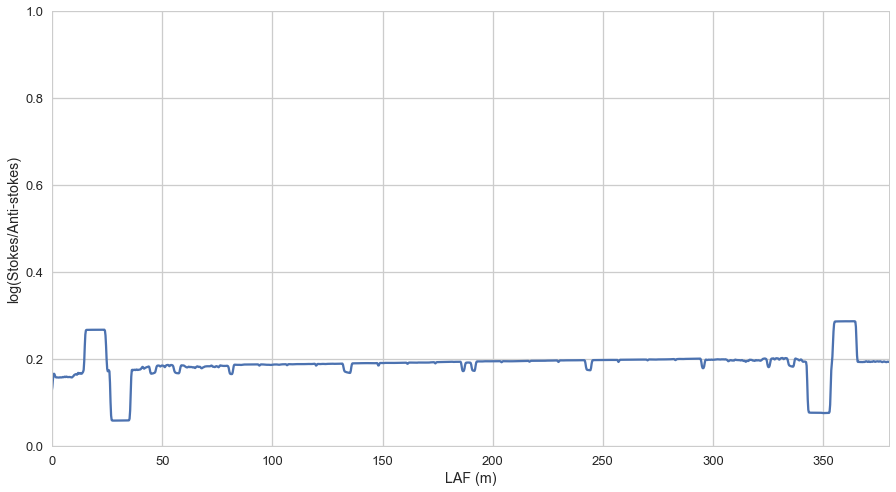

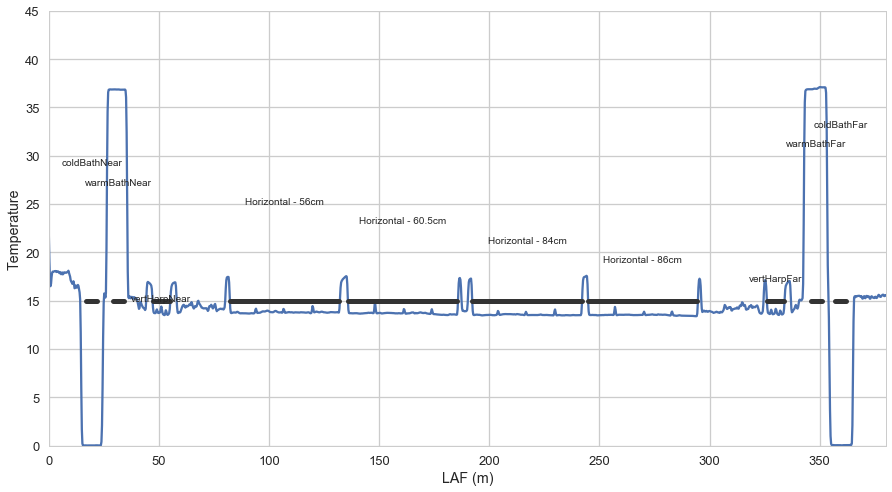

In [12]:
# Stokes and Anti-stokes intensities
startIndex = np.flatnonzero(ds.LAF.values > 0)[0]
plt.figure(figsize=(15, 8))
plt.plot(ds.LAF, ds.Ps.mean(dim='time'), label='Stokes')
plt.plot(ds.LAF, ds.Pas.mean(dim='time'), label='Anti-stokes')

for nl, l in enumerate(location):
    plt.plot([location[l][0], location[l][1]], [5400, 5400], color='0.2', linewidth=5)
    plt.text((location[l][1] + location[l][0]) / 2, 4500 + nl * 100,
             l, horizontalalignment='center')

plt.gca().set_ylim(2500, 6000)
plt.gca().set_ylabel('Intensity')
plt.gca().set_xlabel('LAF (m)')
plt.gca().set_xlim(ds.LAF[startIndex], 380)
plt.legend()

# Log ratio of stokes:anti-stokes
plt.figure(figsize=(15, 8))
plt.plot(ds.LAF, np.log(ds.Ps / ds.Pas).mean(dim='time'))
plt.gca().set_ylim(0, 1)
plt.gca().set_xlim(ds.LAF[startIndex], 380)
plt.gca().set_ylabel('log(Stokes/Anti-stokes)')
plt.gca().set_xlabel('LAF (m)')

# Instrument reported temperatures
plt.figure(figsize=(15, 8))
plt.plot(ds.LAF, ds.temp.mean(dim='time'))

for nl, l in enumerate(location):
    plt.plot([location[l][0], location[l][1]], [15, 15], color='0.2', linewidth=5)
    plt.text((location[l][1] + location[l][0]) / 2, 15 + nl * 2,
             l, horizontalalignment='center')

plt.gca().set_ylim(0, 45)
plt.gca().set_xlim(ds.LAF[startIndex], 380)
plt.gca().set_ylabel('Temperature')
plt.gca().set_xlabel('LAF (m)')



/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log


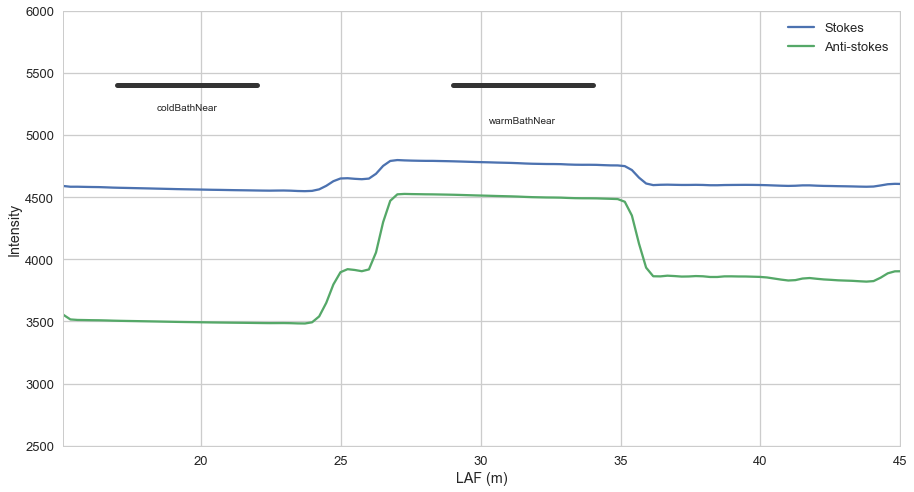

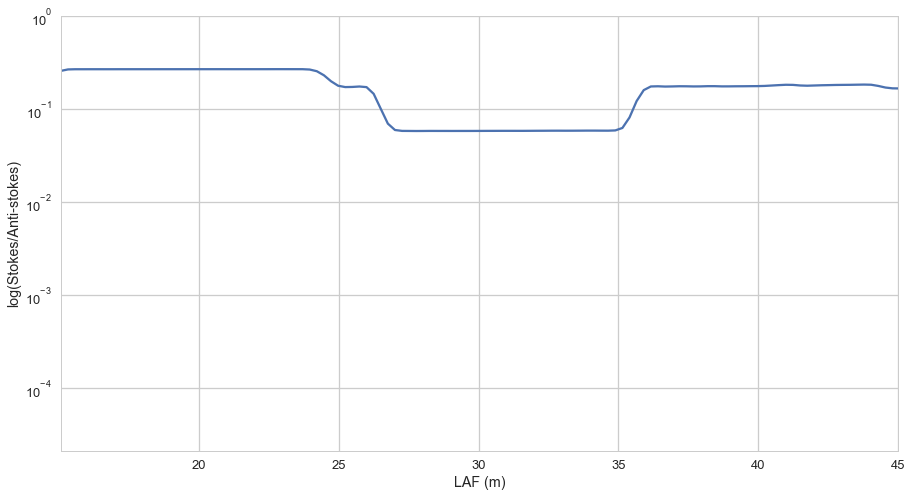

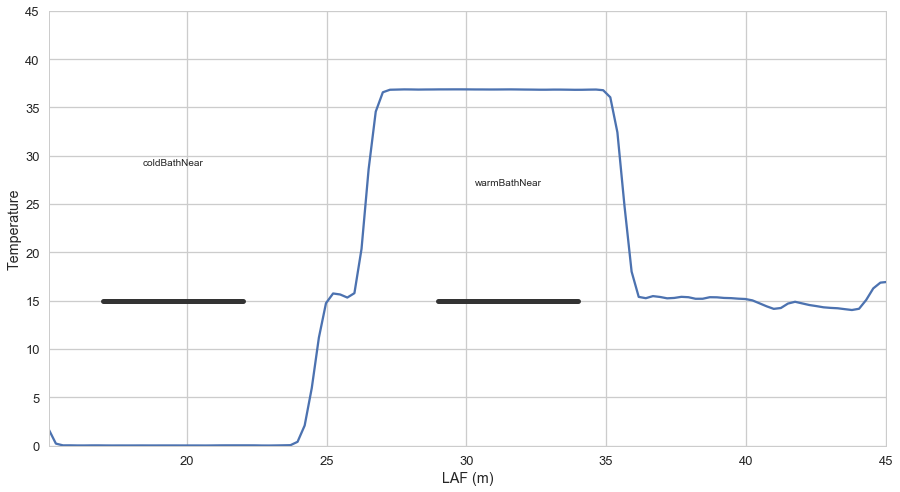

In [9]:
# Stokes and Anti-stokes intensities
startIndex = np.flatnonzero(ds.LAF.values > 15)[0]
plt.figure(figsize=(15, 8))
plt.plot(ds.LAF, ds.Ps.mean(dim='time'), label='Stokes')
plt.plot(ds.LAF, ds.Pas.mean(dim='time'), label='Anti-stokes')

for nl, l in enumerate(location):
    if 'BathNear' not in l:
        continue
    plt.plot([location[l][0], location[l][1]], [5400, 5400], color='0.2', linewidth=5)
    plt.text((location[l][1] + location[l][0]) / 2, 4500 + nl * 100,
             l, horizontalalignment='center')

plt.gca().set_ylim(2500, 6000)
plt.gca().set_ylabel('Intensity')
plt.gca().set_xlabel('LAF (m)')
plt.gca().set_xlim(ds.LAF[startIndex], 45)
plt.legend()

# Log ratio of stokes:anti-stokes
plt.figure(figsize=(15, 8))
plt.semilogy(ds.LAF, np.log(ds.Ps / ds.Pas).mean(dim='time'))
plt.gca().set_ylim(0, 1)
plt.gca().set_xlim(ds.LAF[startIndex], 45)
plt.gca().set_ylabel('log(Stokes/Anti-stokes)')
plt.gca().set_xlabel('LAF (m)')

# Instrument reported temperatures
plt.figure(figsize=(15, 8))
plt.plot(ds.LAF, ds.temp.mean(dim='time'))

for nl, l in enumerate(location):
    if 'BathNear' not in l:
        continue
    plt.plot([location[l][0], location[l][1]], [15, 15], color='0.2', linewidth=5)
    plt.text((location[l][1] + location[l][0]) / 2, 15 + nl * 2,
             l, horizontalalignment='center')

plt.gca().set_ylim(0, 45)
plt.gca().set_xlim(ds.LAF[startIndex], 45)
plt.gca().set_ylabel('Temperature')
plt.gca().set_xlabel('LAF (m)')

